In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [ ]:
!pip install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shareddrives/huy/data.zip -d /content/train

Archive:  /content/drive/Shareddrives/huy/data.zip
   creating: /content/train/data/
   creating: /content/train/data/neg/
  inflating: /content/train/data/neg/0.txt  
  inflating: /content/train/data/neg/1.txt  
  inflating: /content/train/data/neg/10.txt  
  inflating: /content/train/data/neg/100.txt  
  inflating: /content/train/data/neg/1000.txt  
  inflating: /content/train/data/neg/1001.txt  
  inflating: /content/train/data/neg/1002.txt  
  inflating: /content/train/data/neg/1003.txt  
  inflating: /content/train/data/neg/1004.txt  
  inflating: /content/train/data/neg/1005.txt  
  inflating: /content/train/data/neg/1006.txt  
  inflating: /content/train/data/neg/1007.txt  
  inflating: /content/train/data/neg/1008.txt  
  inflating: /content/train/data/neg/1009.txt  
  inflating: /content/train/data/neg/101.txt  
  inflating: /content/train/data/neg/1010.txt  
  inflating: /content/train/data/neg/1011.txt  
  inflating: /content/train/data/neg/1012.txt  
  inflating: /content/t

In [ ]:
!unzip /content/drive/MyDrive/data1.zip -d /content/test1

Archive:  /content/drive/MyDrive/data1.zip
   creating: /content/test1/data1/
   creating: /content/test1/data1/neg/
  inflating: /content/test1/data1/neg/0.txt  
  inflating: /content/test1/data1/neg/1.txt  
  inflating: /content/test1/data1/neg/10.txt  
  inflating: /content/test1/data1/neg/100.txt  
  inflating: /content/test1/data1/neg/1000.txt  
  inflating: /content/test1/data1/neg/1001.txt  
  inflating: /content/test1/data1/neg/1002.txt  
  inflating: /content/test1/data1/neg/1003.txt  
  inflating: /content/test1/data1/neg/1004.txt  
  inflating: /content/test1/data1/neg/1005.txt  
  inflating: /content/test1/data1/neg/1006.txt  
  inflating: /content/test1/data1/neg/1007.txt  
  inflating: /content/test1/data1/neg/1008.txt  
  inflating: /content/test1/data1/neg/1009.txt  
  inflating: /content/test1/data1/neg/101.txt  
  inflating: /content/test1/data1/neg/1010.txt  
  inflating: /content/test1/data1/neg/1011.txt  
  inflating: /content/test1/data1/neg/1012.txt  
  inflating

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train/data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train/data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test_ds = tf.keras.preprocessing.text_dataset_from_directory(
#     '/content/test1/test',
#     batch_size=batch_size)

# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2123 files belonging to 2 classes.
Using 1699 files for training.
Found 2123 files belonging to 2 classes.
Using 424 files for validation.


Let's take a look at a few reviews.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'minh chan ghet xa hoi\r\n'
Label : 0 (neg)
Review: b'minh xau qua\r\n'
Label : 0 (neg)
Review: b'Toi rat kho chiu\r\n'
Label : 0 (neg)


In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = ['hôm nay trời đẹp']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  7570  2213 29349 19817 10448  1102 13699   102     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.897251   -0.30260858 -0.7509011   0.84607804  0.00640062 -0.15452309
  0.9107189   0.28525805 -0.53797424 -0.99998456 -0.2535451   0.81519186]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.71372116  0.20416668 -0.12940972 ...  0.07577956  0.24734354
   0.5026925 ]
 [-0.0595513  -0.17662321  0.0073114  ...  0.2718007   0.56757146
   1.067007  ]
 [ 0.11028232 -0.07404488 -0.5192821  ...  0.6175259  -0.15702124
   0.98278224]
 ...
 [-0.09686024  0.15938835  0.09256696 ...  0.6154078   0.3450969
   0.4093335 ]
 [-0.17257226  0.170802   -0.01075494 ...  0.5809678   0.24627109
   0.40565667]
 [-0.06473033  0.3402552   0.16552296 ...  0.5320816   0.18276964
   0.46592328]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7310586]], shape=(1, 1), dtype=float32)


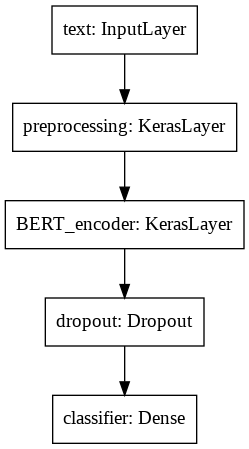

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
import numpy as np
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='min')
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# metrics = tf.metrics.BinaryAccuracy()

In [ ]:
from official import nlp

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)


In [ ]:
# warmup_schedule = nlp.optimization.WarmUp(
#         initial_learning_rate=2e-5,
#         decay_schedule_fn=decay_schedule,
#         warmup_steps=num_warmup_steps)
# opt = nlp.optimization.AdamWeightDecay(
#         learning_rate=warmup_schedule,
#         weight_decay_rate=0.01,
#         epsilon=1e-6,
#         exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [ ]:
import tensorflow_addons as tfa
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=[tf.metrics.BinaryAccuracy(),f1_m,recall_m,precision_m] )

In [ ]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=10)
# model.save("it")
print("...SAVING...")
saved_model_path="italk.h5"
classifier_model.save(saved_model_path, include_optimizer=True)

# callbacks=[checkpoint]

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
54/54 [==============================] - 64s 918ms/step - loss: 0.7995 - binary_accuracy: 0.4741 - f1_m: 0.6407 - recall_m: 1.0000 - precision_m: 0.4740 - val_loss: 0.7037 - val_binary_accuracy: 0.5283 - val_f1_m: 0.6983 - val_recall_m: 1.0000 - val_precision_m: 0.5402
Epoch 2/10
54/54 [==============================] - 49s 914ms/step - loss: 0.6454 - binary_accuracy: 0.4741 - f1_m: 0.6407 - recall_m: 1.0000 - precision_m: 0.4740 - val_loss: 0.6691 - val_binary_accuracy: 0.5283 - val_f1_m: 0.6983 - val_recall_m: 1.0000 - val_precision_m: 0.5402
Epoch 3/10
54/54 [==============================] - 50s 928ms/step - loss: 0.5547 - binary_accuracy: 0.4741 - f1_m: 0.6407 - recall_m: 1.0000 - precision_m: 0.4740 - val_loss: 0.5683 - val_binary_accuracy: 0.5283 - val_f1_m: 0.6983 - val_recall_m: 1.0000 - val_precision_m: 0.5402
Epoch 4/10
54/54 [==============================] - 51s 939ms/step - loss:

KeyboardInterrupt: ignored

In [ ]:
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/test1/',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2123 files belonging to 1 classes.


In [ ]:
loss, accuracy,f1_m,precision_m, recall_m = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'f1: {f1_m}')
print(f'precision: {precision_m}')
print(f'recall: {recall_m}')
# print(f'iou: {iou}')

67/67 [==============================] - 22s 329ms/step - loss: 2.5597 - binary_accuracy: 0.0000e+00 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00
Loss: 2.5596704483032227
Accuracy: 0.0
f1: 0.0
precision: 0.0
recall: 0.0


In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# dataset_name = 'italk'
# saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
saved_model_path="italk.h5"
classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
dataset_name = 'italk'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

In [ ]:
!zip -r italkt.zip /content/italk_bert

In [ ]:
# reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_model = tf.keras.models.load_model(saved_model_path,custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
examples = [
    'minh dang yeu mot nguoi, minh luon cuoi vi ho, ho lam minh hanh phuc',  # this is the same sentence tried earlier
    'hihi',
    'toi buon that su',
    'buon vui',
    'buon'
]
a= tf.constant(examples)
print(a)
b= reloaded_model(a)
print(b)
res=tf.sigmoid(b)
print(res)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()
  return result_for_printing

examples = [
    'minh dang yeu mot nguoi, minh luon cuoi vi ho, ho lam minh hanh phuc',  # this is the same sentence tried earlier
    'hihi',
    'toi buon that su',
    'buon vui',
    'buon'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
# print('Results from the model in memory:')
# print_my_examples(examples, original_results)

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

In [ ]:
!pip install flask-ngrok

In [ ]:
def predict_test(inputs):
	# examples = [
	#     'hôm nay tôi buồn',  # this is the same sentence tried earlier
	#     'The movie was great!',
	#     'tôi vui quá',
	#     'tôi thật sự rất thích',
	#     'hôm nay tệ thật'
	# ]
  global reloaded_model
  # reloaded_results = tf.sigmoid(reloaded_model(tf.constant(inputs)))
  reloaded_results = tf.sigmoid(reloaded_model(tf.constant(inputs)))			# đọc đầu vào
  # original_results = tf.sigmoid(classifier_model(tf.constant(inputs)))			

  # print('Results from the saved model:')
  # print_my_examples(examples, reloaded_results)						#in kết quả đầu ra
  # print('Results from the model in memory:')
  # print_my_examples(examples, original_results)
  serving_results = reloaded_model \
              .signatures['serving_default'](tf.constant(examples))

  serving_results = tf.sigmoid(serving_results['classifier'])

  # print_my_examples(examples, serving_results)
  return serving_results

In [ ]:
# def print_my_examples(inputs, results):
#   result_for_printing = \
#     [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
#                          for i in range(len(inputs))]
#   print(*result_for_printing, sep='\n')
#   print()

In [ ]:
out= print_my_examples(['hôm nay tôi buồn'],predict_test(['hôm nay tôi buồn']))
print(out)

In [ ]:
!pip install flask-ngrok
!pip install jsonpickle


In [ ]:
from flask import Flask
from flask import request,jsonify,make_response,Response
from flask_ngrok import run_with_ngrok
import jsonpickle
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

# for / root, return Hello Word
@app.route("/",methods=['POST'])
def root():
    # url = request.method
    r = request
    # r= jsonpickle.encode(r)
    print(r)
    response = print_my_examples(r,predict_test(r.data.decode('utf-8')))
    # print(response)
    # # encode response using jsonpickle
    # response_pickled = jsonpickle.encode(response)
    response = Response("{}".format(desc), content_type='text/plain')
    # return response
    return response
# app.debug= True
app.run()
# app.run(host="0.0.0.0", port=80, debug=True)

In [ ]:
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def hello():
 return 'Hello World!! from Google Colab'
 
if __name__ == '__main__':
 app.run()

In [ ]:
import socket
print(socket.gethostbyname(socket.getfqdn(socket.gethostname())))

from flask import Flask
app = Flask(__name__)

@app.route("/")
def hello():
    return "Hello World!"

import threading
threading.Thread(target=app.run, kwargs={'host':'0.0.0.0','port':80}).start() 